In [1]:
from ultralytics import YOLO
import cv2
from PIL import Image
import pyrealsense2 as rs
import numpy as np

In [2]:
TRAIN = False
PATH = "data/no-bars_no-classes"

# Segmentation Model

In [4]:
if TRAIN:
    model = YOLO("yolov8s-seg.pt", task="segment")

    EPOCHS = 80
    PATIENCE = 10
    BATCH_SIZE = 8
    IMG_SIZE = 640
    OPTIMIZER = "AdamW"
    LR = 0.002
    SEED = 42

    model.train(data=PATH+"/data.yaml",
                epochs=EPOCHS,
                imgsz=IMG_SIZE,
                optimizer=OPTIMIZER,
                lr0=LR,
                patience=PATIENCE,
                batch=BATCH_SIZE,
                seed=SEED)

In [4]:
if not TRAIN:
    model = YOLO("runs/segment/train4/weights/best.pt",task="detect")

In [6]:
metrics = model.val(split="test")

Ultralytics YOLOv8.0.221 🚀 Python-3.10.11 torch-2.1.1+cpu CPU (11th Gen Intel Core(TM) i7-1165G7 2.80GHz)
YOLOv8s-seg summary (fused): 195 layers, 11779987 parameters, 0 gradients, 42.4 GFLOPs


val: Scanning C:\Users\simon\OneDrive\Schule\2023_WS\THUAS\colruyt\colruyt-destack\vision\data\no-bars_no-classes\test\labels.cache... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


                   all          3         65      0.983          1      0.995      0.893      0.983          1      0.995       0.86
Speed: 2.7ms preprocess, 352.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\segment\val


In [9]:
results = model.predict(source=PATH+"/test/images",
                        save=False,
                        conf=0.5,
                        save_crop=True,
                        project="crops")


image 1/6 c:\Users\simon\OneDrive\Schule\2023_WS\THUAS\colruyt\colruyt-destack\vision\data\no-bars_no-classes\valid\images\CLP06_jpeg.rf.6b30ad7310cf5b4c82ad6f76798bf404.jpg: 640x640 19 Crates, 365.3ms
image 2/6 c:\Users\simon\OneDrive\Schule\2023_WS\THUAS\colruyt\colruyt-destack\vision\data\no-bars_no-classes\valid\images\CLP11_jpeg.rf.967c26e8cab92d12fd28f35e6ab9b7f0.jpg: 640x640 17 Crates, 326.1ms
image 3/6 c:\Users\simon\OneDrive\Schule\2023_WS\THUAS\colruyt\colruyt-destack\vision\data\no-bars_no-classes\valid\images\CLP18_jpeg.rf.cefed98b6cb71707c1caade8459feddd.jpg: 640x640 22 Crates, 309.8ms
image 4/6 c:\Users\simon\OneDrive\Schule\2023_WS\THUAS\colruyt\colruyt-destack\vision\data\no-bars_no-classes\valid\images\CLP24_png.rf.badc0d578a3bf757c8aa5d58fb3fb37b.jpg: 640x640 23 Crates, 311.2ms
image 5/6 c:\Users\simon\OneDrive\Schule\2023_WS\THUAS\colruyt\colruyt-destack\vision\data\no-bars_no-classes\valid\images\CLP28_png.rf.35b22209972382756234112804e7fd26.jpg: 640x640 22 Crates,

In [9]:
for r in results:
    im_array = r.plot()
    im = Image.fromarray(im_array[..., ::-1])
    im.show()

# Classification Model

Possible models

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import keras

from keras import layers
from keras.models import Sequential


In [3]:
batch_size = 16
img_height = 640
img_width = 640

In [4]:
class_dir = "./data/classified-fronts/"

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(class_dir+"/train",
                                                       image_size=(img_height,img_width),
                                                       batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(class_dir+"/valid",
                                                       image_size=(img_height,img_width),
                                                       batch_size=batch_size)

Found 426 files belonging to 4 classes.
Found 122 files belonging to 4 classes.
Found 61 files belonging to 3 classes.


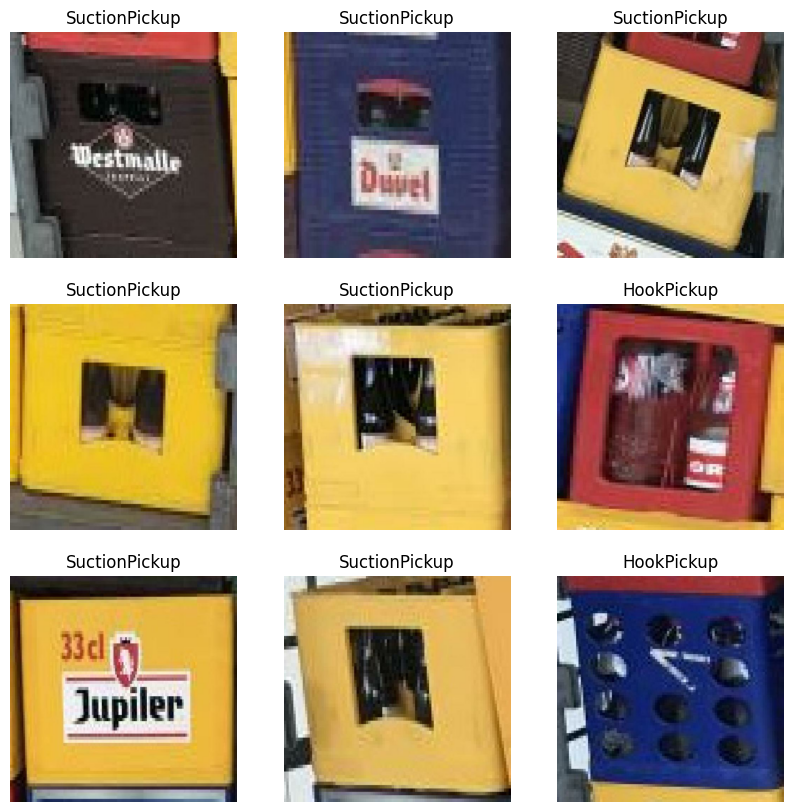

In [6]:
class_names = train_ds.class_names
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 640, 640, 3)
(16,)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
normalization_layer = layers.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 0.9960785


In [11]:
num_classes = len(class_names)

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes)
])

In [12]:
model.compile(optimizer="adamw",
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 640, 640, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 640, 640, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 320, 320, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 320, 320, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 160, 160, 32)      0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 819200)            0

In [14]:
epochs=5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/5


27/27 [==============================] - 29s 1s/step - loss: 10.1896 - accuracy: 0.6244 - val_loss: 0.4349 - val_accuracy: 0.9180
Epoch 2/5
27/27 [==============================] - 27s 1s/step - loss: 0.2713 - accuracy: 0.9319 - val_loss: 0.2187 - val_accuracy: 0.9672
Epoch 3/5
27/27 [==============================] - 27s 1s/step - loss: 0.0626 - accuracy: 0.9836 - val_loss: 0.1376 - val_accuracy: 0.9836
Epoch 4/5
27/27 [==============================] - 28s 1s/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.1331 - val_accuracy: 0.9836
Epoch 5/5
27/27 [==============================] - 28s 1s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1420 - val_accuracy: 0.9836


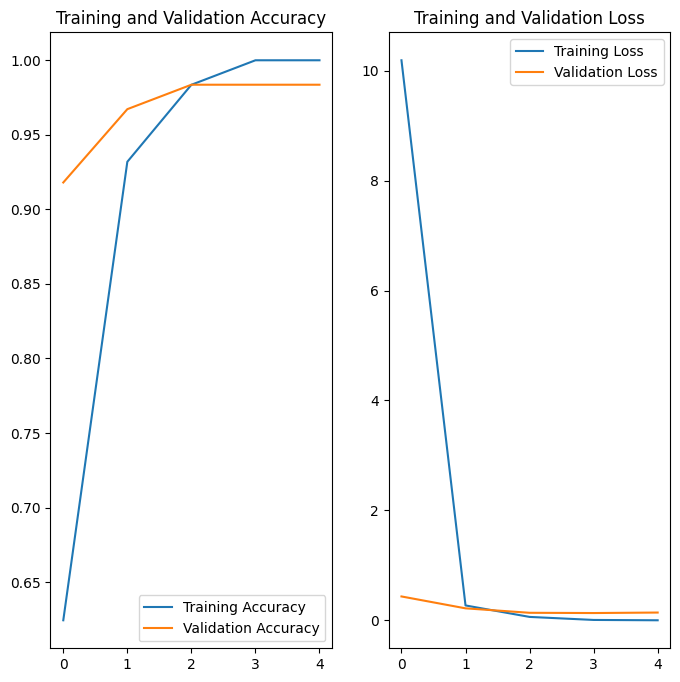

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [17]:
import os

In [24]:
data_dir = "data/classified-fronts/test"
folder_names = ["HookPickup","NoPickup","SuctionPickup"]

for folder in folder_names:
    folder_path = os.path.join(data_dir,folder)
    for file_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file_name)
        img = keras.utils.load_img(img_path)
        img_array = keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array,0)
        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        print(
            "Predicted class: {}, {:.2f} confidence.\nReal class {}"
            .format(class_names[np.argmax(score)], 100 * np.max(score), folder)
        )

1/1 [==============================] - 0s 29ms/step
Predicted class: HookPickup, 100.00 confidence.
Real class HookPickup
1/1 [==============================] - 0s 43ms/step
Predicted class: HookPickup, 100.00 confidence.
Real class HookPickup
1/1 [==============================] - 0s 50ms/step
Predicted class: HookPickup, 100.00 confidence.
Real class HookPickup
1/1 [==============================] - 0s 35ms/step
Predicted class: HookPickup, 100.00 confidence.
Real class HookPickup
1/1 [==============================] - 0s 53ms/step
Predicted class: HookPickup, 100.00 confidence.
Real class HookPickup
1/1 [==============================] - 0s 52ms/step
Predicted class: SuctionPickup, 99.92 confidence.
Real class HookPickup
1/1 [==============================] - 0s 39ms/step
Predicted class: HookPickup, 99.99 confidence.
Real class HookPickup
1/1 [==============================] - 0s 54ms/step
Predicted class: HookPickup, 99.10 confidence.
Real class HookPickup
1/1 [===================

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data/classified-fronts/test\\NoCrate'

# Camera Integration

In [7]:
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)
pipeline.start(config)


#Take image
frames = pipeline.wait_for_frames()
color_frame = frames.get_color_frame()
color_image = np.asanyarray(color_frame.get_data())

#Get Segmentation results
result = model.predict(color_image,
                       save=True,
                       conf=0.5)

pipeline.stop()


0: 384x640 1 NoPickup, 1 SuctionPickup, 147.8ms
Speed: 1.6ms preprocess, 147.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\detect\predict2
